[Source:](https://arxiv.org/pdf/1904.11955)

Let $\sigma : \mathbb{R} \to \mathbb{R}$ be the activation function, and $\mathcal{T}_\sigma : S^+ \to S^+$ be the operator induced by $\sigma$,
\begin{align*}
\forall x, x' \in \mathbb{R}^d, \quad \mathcal{T}_\sigma(K)(x, x') = c_\sigma \mathbb{E}_{(u,v) \sim \mathcal{N}(0, K|_{x,x'})} [\sigma(u)\sigma(v)],
\end{align*}
where $K|_{x,x'} \in \mathbb{R}^{2 \times 2}$, $K|_{x,x'} = \begin{bmatrix} K(x,x) & K(x,x') \\ K(x',x) & K(x',x') \end{bmatrix}$.

For convenience, we use $t_\sigma(\Sigma)$ to denote $c_\sigma \mathbb{E}_{(u,v) \sim \mathcal{N}(0, \Sigma)}[\sigma(u)\sigma(v)]$, and define $\hat{t}_\sigma(\rho)$ as
\begin{align*}
\hat{t}_\sigma(\rho) = c_\sigma \mathbb{E}_{(u,v) \sim \Sigma'}[\sigma(u)\sigma(v)], \text{ with } \Sigma' = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}
\end{align*}

When $\sigma$ is $k$-homogeneous function, we have
\begin{align*}
t_\sigma(\Sigma) = c_\sigma (\Sigma_{11}\Sigma_{22})^{\frac{k}{2}} \mathbb{E}_{(u,v) \sim \mathcal{N}(0, \Sigma')}[\sigma(u)\sigma(v)] \text{ with } \Sigma' = \begin{bmatrix} 1 & \frac{\Sigma_{12}}{\sqrt{\Sigma_{11}\Sigma_{22}}} \\ \frac{\Sigma_{12}}{\sqrt{\Sigma_{11}\Sigma_{22}}} & 1 \end{bmatrix}.
\end{align*}

Thus $t_\sigma(\Sigma)$ can be written as $c_\sigma (\Sigma_{11}\Sigma_{22})^{\frac{k}{2}} \hat{t}_\sigma(\frac{\Sigma_{12}}{\sqrt{\Sigma_{11}\Sigma_{22}}})$.


I have used above formulation for calculation of $\Theta_{theory}$ and for $k=1$




Width 5 	 Max Diff Error: 3.147179
Width 10 	 Max Diff Error: 1.413505
Width 20 	 Max Diff Error: 0.877852
Width 50 	 Max Diff Error: 0.334017
Width 100 	 Max Diff Error: 0.161461
Width 150 	 Max Diff Error: 0.108543
Width 200 	 Max Diff Error: 0.080328
Width 250 	 Max Diff Error: 0.064084
Width 300 	 Max Diff Error: 0.054721
Width 500 	 Max Diff Error: 0.032062
Width 700 	 Max Diff Error: 0.022796
Width 800 	 Max Diff Error: 0.019783
Width 900 	 Max Diff Error: 0.017682
Width 1000 	 Max Diff Error: 0.015922
Width 1500 	 Max Diff Error: 0.010708
Width 2000 	 Max Diff Error: 0.007991
Width 3000 	 Max Diff Error: 0.005300
Width 4000 	 Max Diff Error: 0.004018


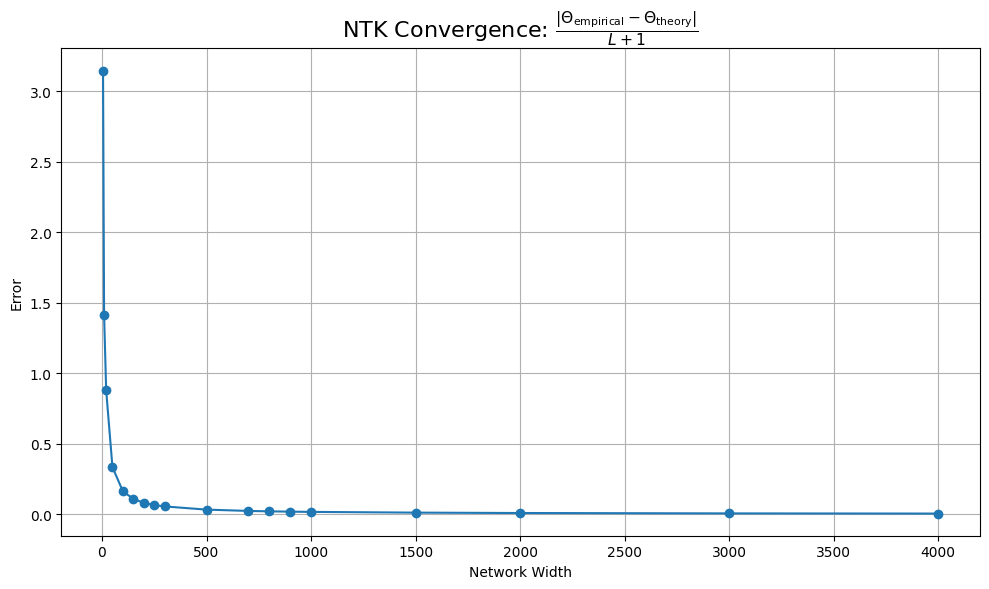

[3.147179365158081,
 1.4135054349899292,
 0.8778518438339233,
 0.3340170681476593,
 0.1614612191915512,
 0.10854300111532211,
 0.08032801747322083,
 0.06408371776342392,
 0.05472060292959213,
 0.03206171840429306,
 0.022795584052801132,
 0.019782550632953644,
 0.017681753262877464,
 0.01592213287949562,
 0.010708033107221127,
 0.007990752346813679,
 0.005299980752170086,
 0.0040179528295993805]

In [2]:
import torch
import numpy as np
from typing import Optional, Tuple, List, Union
from torch.func import functional_call, vmap, grad, jacrev
import torch.nn.functional as F


def relu_kernel_covariance(K: torch.Tensor) -> torch.Tensor:
    """
    Compute Σ^(h) for ReLU activation given Λ^(h)
    Args:
        K: 2x2 matrix Λ^(h)(x,x') containing dot products
    
    Implements formula from Fact E.1:
    tˆσ(ρ) = (√(1−ρ²) + ρ·arcsin(ρ))/π + ρ/2
    where cσ = 2
    """
    # Extract values from K matrix
    k_xx = K[0, 0]  # Σ^(h-1)(x,x)
    k_xy = K[0, 1]  # Σ^(h-1)(x,x')
    k_yy = K[1, 1]  # Σ^(h-1)(x',x')
    
    # Compute correlation coefficient (ρ)
    rho = k_xy / torch.sqrt(k_xx * k_yy + 1e-12)
    rho = torch.clamp(rho, -1.0 + 1e-6, 1.0 - 1e-6)  # Numerical stability
    
    # Implement tˆσ(ρ) directly using the formula from Fact E.1.3
    sqrt_term = torch.sqrt(1 - rho**2)
    arcsin_term = torch.arcsin(rho)
    t_sigma = (sqrt_term + rho * arcsin_term) / np.pi + rho / 2
    
    # Apply c_σ = 2 and scale by the norms
    return 2 * (k_xx * k_yy)**(1/2) * t_sigma ## 1/2 for k=1 from k-Homogenous Function property

def relu_kernel_derivative(K: torch.Tensor) -> torch.Tensor:
    """
    Compute Σ̇^(h) for ReLU activation given Λ^(h)
    Args:
        K: 2x2 matrix Λ^(h)(x,x') containing dot products
        
    Implements formula from Fact E.1:
    tˆσ̇(ρ) = 1/2 + arcsin(ρ)/π
    """
    # Extract values from K matrix
    k_xx = K[0, 0]  # Σ^(h-1)(x,x)
    k_xy = K[0, 1]  # Σ^(h-1)(x,x')
    k_yy = K[1, 1]  # Σ^(h-1)(x',x')
    
    # Compute correlation coefficient (ρ)
    rho = k_xy / torch.sqrt(k_xx * k_yy + 1e-12)
    rho = torch.clamp(rho, -1.0 + 1e-6, 1.0 - 1e-6)  # Numerical stability
    
    # Implement tˆσ̇(ρ) directly using the formula from Fact E.1.3
    return 0.5 + torch.arcsin(rho) / np.pi

def theoretical_ntk(X1: torch.Tensor, 
                    X2: Optional[torch.Tensor] = None, 
                    L: int = 2) -> torch.Tensor:
    """
    Compute theoretical NTK for fully-connected neural network with ReLU activation.
    
    Args:
        X1: Input tensor of shape (n1, d)
        X2: Input tensor of shape (n2, d), if None, X2 = X1
        L: Number of hidden layers in the network
    
    Returns:
        Θ: Theoretical NTK matrix of shape (n1, n2)
    """
    if X2 is None:
        X2 = X1

    # Normalize inputs by input dimension (needed for consistent scaling)
    X1 = X1 / np.sqrt(X1.shape[1])
    X2 = X2 / np.sqrt(X2.shape[1])
    
    n1, n2 = X1.shape[0], X2.shape[0]
    Sigma = torch.zeros((L+1, n1, n2), dtype=X1.dtype)
    Sigma_dot = torch.zeros((L+1, n1, n2), dtype=X1.dtype)
    Theta = torch.zeros((n1, n2), dtype=X1.dtype)
    
    # Compute initial kernel: Σ^(0)(x,x') = x^T x'
    Sigma[0] = X1 @ X2.T
    
    # Recursively compute covariance matrices for each layer
    for h in range(1, L+1):
        for i in range(n1):
            for j in range(n2):
                # Build 2x2 covariance matrix for pair (x_i, x_j)
                Lambda = torch.tensor([
                    [Sigma[h-1, i, i], Sigma[h-1, i, j]],
                    [Sigma[h-1, i, j], Sigma[h-1, j, j]]
                ])

                # Compute next-layer covariance
                Sigma[h, i, j] = relu_kernel_covariance(Lambda)
                
                # Compute derivative covariance
                Sigma_dot[h, i, j] = relu_kernel_derivative(Lambda)
    
    # Compute the NTK using equation (9)
    for h in range(1, L+1):
        # Extract Σ^(h-1)(x,x')
        sigma_term = Sigma[h-1]
        
        # Compute product of derivative terms
        deriv_product = torch.ones((n1, n2), device=X1.device, dtype=X1.dtype)
        for h_prime in range(h, L+1):
            deriv_product *= Sigma_dot[h_prime]
        
        # Add contribution from this layer
        Theta += sigma_term * deriv_product
    
    return Theta

def compare_ntk_empirical_vs_theoretical(X, width_list=None):
    """
    Compare empirical NTK with theoretical NTK across different widths
    
    Args:
        X: Input data tensor of shape (n, d)
        width_list: List of network widths to test
    
    Returns:
        Plots comparing empirical and theoretical NTK
    """
    if width_list is None:
        width_list = [5, 10, 20, 50, 100, 150, 200, 250, 300, 500, 700, 800, 900, 1000, 1500, 2000, 3000, 4000]
    
    # Compute theoretical NTK once (constant regardless of width)
    K_theory = theoretical_ntk(X, L=3)
    
    rel_errors = []
    
    for width in width_list:
        # Set random seed for reproducibility
        torch.manual_seed(42)

        # Initialize parameters for a 2-layer network
        W1 = torch.randn(width, X.shape[1]) / np.sqrt(X.shape[1]/2)
        b1 = torch.zeros(width)
        W2 = torch.randn(width, width) / np.sqrt(width)
        b2 = torch.zeros(width)
        W3 = torch.randn(1, width) / np.sqrt(width)
        b3 = torch.zeros(1)

        def f(x, W1, W2, W3, b1, b2, b3):
          layer1 = F.relu(x@(W1.T)+b1)
          layer2 = F.relu(layer1@(W2.T)+b2)
          layer3 = layer2@(W3.T) + b3
          layer3 = layer3.view(-1)
          return layer3


        jacobian = jacrev(f, argnums= (1, 2, 3, 4))(X, W1, W2, W3, b1, b2, b3)
        K_emp = torch.stack([j.flatten(1)@k.flatten(1).T for j,k in zip(jacobian, jacobian)]).sum(0)
        
        # Scale empirical NTK appropriately
        K_emp = K_emp / width # This is done to make ε small.

        # Compute error
        # |⟨∂f(θ,x)/∂θ, ∂f(θ,x')/∂θ⟩ - Θ^(L)(x,x')| ≤ (L+1)ε
        rel_error = torch.max(torch.abs(K_emp - K_theory)) / torch.tensor(width + 1)
        rel_errors.append(rel_error.item())

        
        print(f"Width {width} \t Max Diff Error: {rel_error:.6f}")
    
    # Plot results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(width_list, rel_errors, 'o-')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Network Width')
    plt.ylabel('Error')
    plt.title(r'NTK Convergence: $\frac{| \Theta_{\text{empirical}} - \Theta_{\text{theory}} |}{ L + 1}$', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return rel_errors

# Example usage:
X = torch.randn(25, 5) 
compare_ntk_empirical_vs_theoretical(X)


Width 5 	 Max Diff Error: 2.806151
Width 10 	 Max Diff Error: 1.216576
Width 20 	 Max Diff Error: 0.760912
Width 50 	 Max Diff Error: 0.367451
Width 100 	 Max Diff Error: 0.180237
Width 150 	 Max Diff Error: 0.121440
Width 200 	 Max Diff Error: 0.089082
Width 250 	 Max Diff Error: 0.070470
Width 300 	 Max Diff Error: 0.059646
Width 500 	 Max Diff Error: 0.035819
Width 700 	 Max Diff Error: 0.025517
Width 800 	 Max Diff Error: 0.022178
Width 900 	 Max Diff Error: 0.019672
Width 1000 	 Max Diff Error: 0.017686
Width 1500 	 Max Diff Error: 0.011889
Width 2000 	 Max Diff Error: 0.008908
Width 3000 	 Max Diff Error: 0.005872
Width 4000 	 Max Diff Error: 0.004404


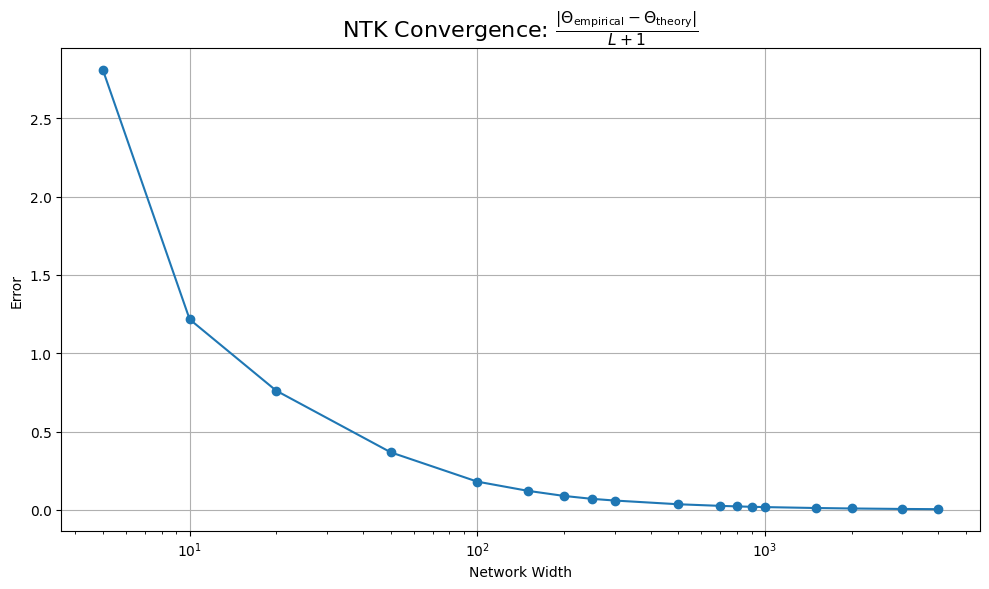

[2.8061506748199463,
 1.216576099395752,
 0.7609117031097412,
 0.3674509823322296,
 0.1802370548248291,
 0.12144048511981964,
 0.08908209204673767,
 0.07046997547149658,
 0.059646446257829666,
 0.035818614065647125,
 0.025516699999570847,
 0.022178441286087036,
 0.01967158354818821,
 0.017686491832137108,
 0.01188885048031807,
 0.008907687850296497,
 0.0058721741661429405,
 0.004403797909617424]

In [ ]:
import torch
import numpy as np
from typing import Optional, Tuple, List, Union
from torch.func import functional_call, vmap, grad, jacrev
import torch.nn.functional as F


def relu_kernel_covariance(K: torch.Tensor) -> torch.Tensor:
    """
    Compute Σ^(h) for ReLU activation given Λ^(h)
    Args:
        K: 2x2 matrix Λ^(h)(x,x') containing dot products
    
    Implements formula from Fact E.1:
    tˆσ(ρ) = (√(1−ρ²) + ρ·arcsin(ρ))/π + ρ/2
    where cσ = 2
    """
    # Extract values from K matrix
    k_xx = K[0, 0]  # Σ^(h-1)(x,x)
    k_xy = K[0, 1]  # Σ^(h-1)(x,x')
    k_yy = K[1, 1]  # Σ^(h-1)(x',x')
    
    # Compute correlation coefficient (ρ)
    rho = k_xy / torch.sqrt(k_xx * k_yy + 1e-12)
    rho = torch.clamp(rho, -1.0 + 1e-6, 1.0 - 1e-6)  # Numerical stability
    
    # Implement tˆσ(ρ) directly using the formula from Fact E.1.3
    sqrt_term = torch.sqrt(1 - rho**2)
    arcsin_term = torch.arcsin(rho)
    t_sigma = (sqrt_term + rho * arcsin_term) / np.pi + rho / 2
    
    # Apply c_σ = 2 and scale by the norms
    return 2 * (k_xx * k_yy)**(1/2) * t_sigma ## 1/2 for k=1 from k-Homogenous Function property

def relu_kernel_derivative(K: torch.Tensor) -> torch.Tensor:
    """
    Compute Σ̇^(h) for ReLU activation given Λ^(h)
    Args:
        K: 2x2 matrix Λ^(h)(x,x') containing dot products
        
    Implements formula from Fact E.1:
    tˆσ̇(ρ) = 1/2 + arcsin(ρ)/π
    """
    # Extract values from K matrix
    k_xx = K[0, 0]  # Σ^(h-1)(x,x)
    k_xy = K[0, 1]  # Σ^(h-1)(x,x')
    k_yy = K[1, 1]  # Σ^(h-1)(x',x')
    
    # Compute correlation coefficient (ρ)
    rho = k_xy / torch.sqrt(k_xx * k_yy + 1e-12)
    rho = torch.clamp(rho, -1.0 + 1e-6, 1.0 - 1e-6)  # Numerical stability
    
    # Implement tˆσ̇(ρ) directly using the formula from Fact E.1.3
    return 0.5 + torch.arcsin(rho) / np.pi

def theoretical_ntk(X1: torch.Tensor,
                    X2: Optional[torch.Tensor] = None,
                    L: int = 2) -> torch.Tensor:
    if X2 is None:
        X2 = X1

    # Normalize inputs by input dimension
    X1 = X1 / np.sqrt(X1.shape[1])
    X2 = X2 / np.sqrt(X2.shape[1])
    
    n1, n2 = X1.shape[0], X2.shape[0]
    
    # Initialize dynamic programming tables
    Sigma = [X1 @ X2.T]  # Cross-kernel between X1 and X2
    Sigma_dot = []       # Derivative terms
    Theta = torch.zeros((n1, n2), dtype=X1.dtype, device=X1.device)
    
    # Precompute self-kernels if inputs are different
    if X1 is not X2:
        Sigma_X1 = [X1 @ X1.T]
        Sigma_X2 = [X2 @ X2.T]
        
        # Build self-kernels using DP
        for h in range(1, L):
            diag1 = torch.diagonal(Sigma_X1[-1]).unsqueeze(1)
            norms1 = torch.sqrt(diag1 @ diag1.T + 1e-12)
            rho1 = Sigma_X1[-1] / norms1
            sqrt_term1 = torch.sqrt(1 - rho1**2)
            arcsin1 = torch.arcsin(rho1)
            Sigma_X1.append(2 * norms1 * ((sqrt_term1 + rho1 * arcsin1) / torch.pi + rho1 / 2))
            
            diag2 = torch.diagonal(Sigma_X2[-1]).unsqueeze(1)
            norms2 = torch.sqrt(diag2 @ diag2.T + 1e-12)
            rho2 = Sigma_X2[-1] / norms2
            sqrt_term2 = torch.sqrt(1 - rho2**2)
            arcsin2 = torch.arcsin(rho2)
            Sigma_X2.append(2 * norms2 * ((sqrt_term2 + rho2 * arcsin2) / torch.pi + rho2 / 2))

    # Build cross-kernels using DP
    for h in range(1, L+1):
        if X1 is X2:  # Same inputs
            diag = torch.diagonal(Sigma[-1]).unsqueeze(1)
            norms = torch.sqrt(diag @ diag.T + 1e-12)
        else:  # Different inputs
            diag1 = torch.diagonal(Sigma_X1[h-1]).unsqueeze(1) if h > 1 else torch.diagonal(Sigma_X1[0]).unsqueeze(1)
            diag2 = torch.diagonal(Sigma_X2[h-1]).unsqueeze(0) if h > 1 else torch.diagonal(Sigma_X2[0]).unsqueeze(0)
            norms = torch.sqrt(diag1 * diag2 + 1e-12)
        
        rho = Sigma[-1] / norms
        sqrt_term = torch.sqrt(1 - rho**2)
        arcsin_rho = torch.arcsin(rho)
        
        # Update DP tables
        Sigma.append(2 * norms * ((sqrt_term + rho * arcsin_rho) / torch.pi + rho / 2))
        Sigma_dot.append(0.5 + arcsin_rho / torch.pi)

    # Compute NTK using DP tables
    for h in range(L):
        # Compute product of derivatives from current layer to final layer
        deriv_product = torch.ones((n1, n2), device=X1.device, dtype=X1.dtype)
        for h_prime in range(h, L):
            deriv_product *= Sigma_dot[h_prime]
        
        Theta += Sigma[h] * deriv_product

    return Theta


def compare_ntk_empirical_vs_theoretical(X, width_list=None):
    """
    Compare empirical NTK with theoretical NTK across different widths
    
    Args:
        X: Input data tensor of shape (n, d)
        width_list: List of network widths to test
    
    Returns:
        Plots comparing empirical and theoretical NTK
    """
    if width_list is None:
        width_list = [5, 10, 20, 50, 100, 150, 200, 250, 300, 500, 700, 800, 900, 1000, 1500, 2000, 3000, 4000]
    
    # Compute theoretical NTK once (constant regardless of width)
    K_theory = theoretical_ntk(X, L=3)
    
    rel_errors = []
    
    for width in width_list:
        # Set random seed for reproducibility
        torch.manual_seed(42)

        # Initialize parameters for a 2-layer network
        W1 = torch.randn(width, X.shape[1]) / np.sqrt(X.shape[1]/2)
        b1 = torch.zeros(width)
        W2 = torch.randn(width, width) / np.sqrt(width)
        b2 = torch.zeros(width)
        W3 = torch.randn(1, width) / np.sqrt(width)
        b3 = torch.zeros(1)

        def f(x, W1, W2, W3, b1, b2, b3):
          layer1 = F.relu(x@(W1.T)+b1)
          layer2 = F.relu(layer1@(W2.T)+b2)
          layer3 = layer2@(W3.T) + b3
          layer3 = layer3.view(-1)
          return layer3


        jacobian = jacrev(f, argnums= (1, 2, 3, 4))(X, W1, W2, W3, b1, b2, b3)
        K_emp = torch.stack([j.flatten(1)@k.flatten(1).T for j,k in zip(jacobian, jacobian)]).sum(0)
        
        # Scale empirical NTK appropriately
        K_emp = K_emp / width # This is done to make ε small.

        # Compute error
        # |⟨∂f(θ,x)/∂θ, ∂f(θ,x')/∂θ⟩ - Θ^(L)(x,x')| ≤ (L+1)ε
        rel_error = torch.max(torch.abs(K_emp - K_theory)) / torch.tensor(width + 1)
        rel_errors.append(rel_error.item())

        
        print(f"Width {width} \t Max Diff Error: {rel_error:.6f}")
    
    # Plot results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(width_list, rel_errors, 'o-')
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Network Width')
    plt.ylabel('Error')
    plt.title(r'NTK Convergence: $\frac{| \Theta_{\text{empirical}} - \Theta_{\text{theory}} |}{ L + 1}$', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return rel_errors

# Example usage:
X = torch.randn(25, 5) 
compare_ntk_empirical_vs_theoretical(X)


In [3]:
!pip install tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


Running on device: cpu

Computing NTK
Training neural network with width 5


Training NN:   0%|          | 0/1000 [00:00<?, ?it/s]

Training NN: 100%|██████████| 1000/1000 [00:00<00:00, 1807.96it/s]


Width 5, Relative difference: 0.884562
Training neural network with width 10


Training NN: 100%|██████████| 1000/1000 [00:00<00:00, 1961.47it/s]


Width 10, Relative difference: 0.997354
Training neural network with width 20


Training NN: 100%|██████████| 1000/1000 [00:00<00:00, 2082.83it/s]


Width 20, Relative difference: 1.005076
Training neural network with width 50


Training NN: 100%|██████████| 1000/1000 [00:00<00:00, 1788.61it/s]


Width 50, Relative difference: 0.760827
Training neural network with width 100


Training NN: 100%|██████████| 1000/1000 [00:00<00:00, 1846.59it/s]


Width 100, Relative difference: 0.488566
Training neural network with width 150


Training NN: 100%|██████████| 1000/1000 [00:00<00:00, 1547.85it/s]


Width 150, Relative difference: 0.357571
Training neural network with width 200


Training NN: 100%|██████████| 1000/1000 [00:00<00:00, 1423.79it/s]


Width 200, Relative difference: 0.346300
Training neural network with width 250


Training NN: 100%|██████████| 1000/1000 [00:00<00:00, 1225.22it/s]


Width 250, Relative difference: 0.247600
Training neural network with width 300


Training NN: 100%|██████████| 1000/1000 [00:01<00:00, 911.18it/s]


Width 300, Relative difference: 0.123393
Training neural network with width 400


Training NN: 100%|██████████| 1000/1000 [00:01<00:00, 810.31it/s]


Width 400, Relative difference: 0.138674
Training neural network with width 500


Training NN: 100%|██████████| 1000/1000 [00:01<00:00, 607.87it/s]


Width 500, Relative difference: 0.102616
Training neural network with width 800


Training NN: 100%|██████████| 1000/1000 [00:03<00:00, 310.67it/s]


Width 800, Relative difference: 0.074367
Experiment completed. Check the output figures.


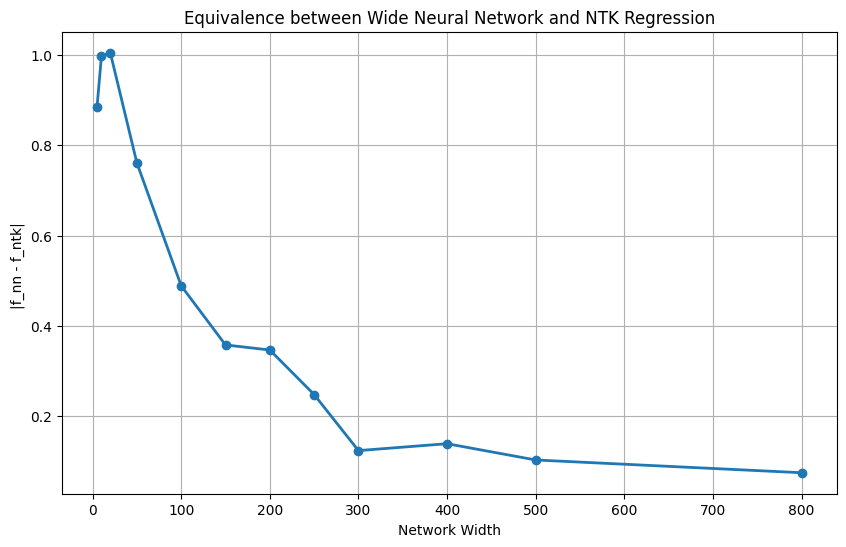

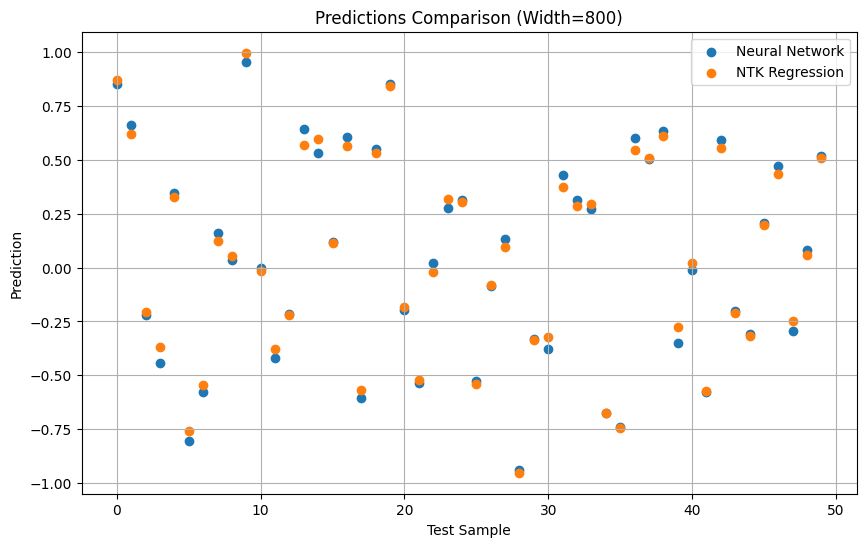

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Generate synthetic data
def generate_data(n_samples=100, dim=5):
    X = torch.randn(n_samples, dim).to(device)
    # Normalize inputs as required by theorem
    X = X / torch.norm(X, dim=1, keepdim=True)
    w_true = torch.randn(dim, 1).to(device)
    y = X @ w_true + 0.1 * torch.randn(n_samples, 1).to(device)
    return X, y

# 2. Wide Neural Network implementation
class WideNN(nn.Module):
    def __init__(self, input_dim, width, depth=2, scale=0.1):
        super().__init__()
        self.scale = scale
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_dim, width))
        
        # Hidden layers
        for _ in range(depth-1):
            self.layers.append(nn.Linear(width, width))
            
        # Output layer
        self.layers.append(nn.Linear(width, 1))
        
        # Initialize with proper scaling (crucial for NTK theory)
        for i, layer in enumerate(self.layers):
            if i == 0:
                nn.init.normal_(layer.weight, std=1.0/np.sqrt(input_dim/2))
            else:
                nn.init.normal_(layer.weight, std=1.0/np.sqrt(width/2))
            nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = F.relu(layer(x))
            else:
                # Apply scaling factor κ to final output
                x = self.scale * layer(x)
        return x




# 4. Kernel regression using NTK
def ntk_regression(ntk_train, y_train, ntk_test, reg=1e-4):
    """Implement kernel regression using NTK: f_ntk(x_te) = ker_ntk(x_te, X)^T (H*)^-1 y"""
    n = ntk_train.shape[0]
    # Add regularization for numerical stability
    reg_matrix = reg * torch.eye(n).to(device)
    solution = torch.linalg.solve(ntk_train + reg_matrix, y_train)
    return ntk_test.T @ solution

# 5. Train wide neural network
def train_nn(model, X_train, y_train, epochs=1000, lr=0.01):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses = []
    
    for epoch in tqdm(range(epochs), desc="Training NN"):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return losses

# 6. Experiment: Compare predictions for different widths & # 3. NTK Computation

def run_experiment(widths=[10, 100, 1000, 10000], n_samples=50, input_dim=5):
    # Generate data
    X_train, y_train = generate_data(n_samples=n_samples, dim=input_dim)
    X_test, y_test = generate_data(n_samples=n_samples, dim=input_dim)
    ntk_train = theoretical_ntk(X_train, L=2)
    ntk_test = theoretical_ntk(X_train, X_test, L=2)
    results = []
    # Compute NTK before training
    print(f"\nComputing NTK")
    K_train = ntk_train
    K_test = ntk_test
    
    # NTK regression
    y_ntk = ntk_regression(K_train, y_train, K_test)
    for width in widths:
        # Initialize model
        model = WideNN(input_dim=input_dim, width=width, scale=0.1).to(device)
        

        
        # Train neural network
        print(f"Training neural network with width {width}")
        train_nn(model, X_train, y_train)
        
        # NN prediction
        with torch.no_grad():
            y_nn = model(X_test)
        
        # Measure difference
        diff = torch.max(torch.abs(y_nn - y_ntk)) # Max Absolute Difference
        
        results.append({
            'width': width,
            'relative_difference': diff.detach().numpy(),
            'y_nn': y_nn.detach().numpy(),
            'y_ntk': y_ntk.detach().numpy()
        })
        
        print(f"Width {width}, Relative difference: {diff:.6f}")
    
    return results

# 7. Plot results
def plot_results(results):
    # Plot difference vs width
    widths = [r['width'] for r in results]
    diffs = [r['relative_difference'] for r in results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(widths, diffs, 'o-', linewidth=2)
    plt.xlabel('Network Width')
    plt.ylabel('|f_nn - f_ntk| ')
    plt.title('Equivalence between Wide Neural Network and NTK Regression')
    plt.grid(True)
    plt.savefig('ntk_equivalence.png')
    
    # Plot predictions comparison for widest network
    plt.figure(figsize=(10, 6))
    idx = -1  # Widest network Las network
    plt.scatter(range(len(results[idx]['y_nn'])), results[idx]['y_nn'], label='Neural Network')
    plt.scatter(range(len(results[idx]['y_ntk'])), results[idx]['y_ntk'], label='NTK Regression')

    
    plt.xlabel('Test Sample')
    plt.ylabel('Prediction')
    plt.title(f'Predictions Comparison (Width={results[idx]["width"]})')
    plt.legend()
    plt.grid(True)
    plt.savefig('predictions_comparison.png')

# Run experiment with smaller widths for demonstration
if __name__ == "__main__":
    print(f"Running on device: {device}")
    # Use smaller values for demonstration
    results = run_experiment(widths=[5,10, 20, 50, 100, 150, 200, 250, 300, 400, 500, 800 ], n_samples=50, input_dim=5)
    plot_results(results)
    print("Experiment completed. Check the output figures.")
